In [14]:
import pandas as pd 
from enum import Enum
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from typing import List
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt 

In [15]:
DATASET = '../propaganda_dataset_v2'
train = pd.read_csv(f'{DATASET}/propaganda_train.tsv', sep='\t', header=0, quoting=3)
val = pd.read_csv(f'{DATASET}/propaganda_val.tsv', sep='\t', header=0, quoting=3)

stopwords = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [16]:
set(train['label'])

{'appeal_to_fear_prejudice',
 'causal_oversimplification',
 'doubt',
 'exaggeration,minimisation',
 'flag_waving',
 'loaded_language',
 'name_calling,labeling',
 'not_propaganda',
 'repetition'}

# Bag Of Words Classifier

In [18]:
def extract_snippet(s: str) -> str:
    start = '<BOS>'
    end = '<EOS>'
    s_idx = s.index(start) + len(start)
    e_idx = s.index(end) 
    return s[s_idx:e_idx]

def is_valid_word(word: str) -> bool: 
    if word is None:
        return False 

    is_stopword = word in stopwords 
    is_alpha = all(c.isalpha() and ord(c) < 128 for c in word)

    return not is_stopword and is_alpha

def process_words(words: List[str], use_lemmatizer=True) -> List[str]:
    """ 
    Preprocess a list of words. Remove all occurances of `None`, stopwords, 
    and words made up of non-alphabetical characters 
    """
    valid_words = list(filter(is_valid_word, words))
    stemmed = map(lemmatizer.lemmatize if use_lemmatizer else stemmer.stem, valid_words)
    return list(stemmed)
   


# Get all words tagged as propaganda
propaganda_words = [
    word.lower() 
    if label != "not_propaganda" else None
    for _, (label, sample) in train.iterrows() 
    for word in word_tokenize(extract_snippet(sample))
]
words = [
    word.lower() 
    for _, (_, sample) in train.iterrows() 
    for word in word_tokenize(sample)
]

propaganda_words = set(process_words(propaganda_words))
words = process_words(words)

## Unigram Precision 

In [19]:
from sklearn.linear_model import LogisticRegression

def unigram_precision(words: List[str]) -> float: 
    num_words = len(words)
    common = set(words) & set(propaganda_words)
    return len(common) / num_words

predictions = []
for i, (label, sample) in val.iterrows():
    percentage_correct = unigram_precision(word_tokenize(sample)) 
    predictions.append(percentage_correct)
    
labels = ['propaganda' if label != 'not_propaganda' else 'not_propaganda' for label in val.iloc[:, 0]]
classifier = LogisticRegression() 

train_vals = np.array([unigram_precision(process_words(word_tokenize(sample))) for _, (label, sample) in train.iterrows()])
train_labels = np.array([1.0 if label != 'not_propaganda' else 0.0 for _, (label, _) in train.iterrows()])
train_vals = np.reshape(train_vals, (-1, 1))
train_labels = np.reshape(train_labels, (-1, 1))

classifier.fit(train_vals, train_labels)
predictions = np.zeros_like(val.iloc[:, 0])
predictions = np.reshape(predictions, (-1, 1))

for i, (label, sample) in val.iterrows(): 
    model = np.array([[unigram_precision(process_words(word_tokenize(sample)))]])
    predictions[i] = classifier.predict(model)
gt_labels = [1.0 if label != 'not_propaganda' else 0.0 for label in val.iloc[:, 0]]
gt_labels = np.reshape(gt_labels, (-1, 1)).astype(np.float32)
predictions = predictions.astype(np.float32)
print(classification_report(gt_labels, predictions))

/Users/henrywilliams/Documents/uni/anle/assessment/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


precision    recall  f1-score   support

         0.0       0.61      0.67      0.64       331
         1.0       0.61      0.54      0.57       309

    accuracy                           0.61       640
   macro avg       0.61      0.61      0.60       640
weighted avg       0.61      0.61      0.61       640

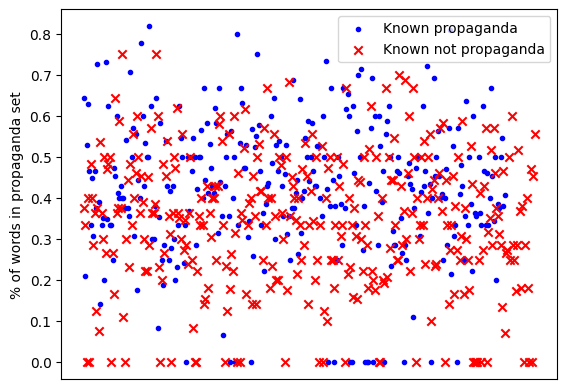

In [31]:
model = np.array([[unigram_precision(process_words(word_tokenize(sample))), 1.0 if label != 'not_propaganda' else 0.0] 
         for i, (label, sample) in val.iterrows()])
propaganda = model[model[:, 1] == 1.]
not_propaganda = model[model[:, 1] == 0.]


m, c = classifier.coef_, classifier.intercept_
plt.scatter(np.arange(len(propaganda[:, 0])), propaganda[:, 0], marker='.', c='b', label="Known propaganda")
plt.scatter(np.arange(len(not_propaganda[:, 0])), not_propaganda[:, 0], marker='x', c='r', label="Known not propaganda")
plt.ylabel("% of words in propaganda set")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.savefig('./assets/bag-of-words-correlation.png', dpi=512)